In [ ]:
import pandas as pd

# Load raw CSV files for each park
df_portaventura = pd.read_csv(RAW_DIR / "portaventura.csv")
df_warner = pd.read_csv(RAW_DIR / "warner.csv")
df_pam = pd.read_csv(RAW_DIR / "parque_atracciones_madrid.csv")

/tmp/ipython-input-1116667225.py:4: DtypeWarning: Columns (26,27,28,29,30,31,32,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86) have mixed types. Specify dtype option on import or set low_memory=False.
  df_portaventura = pd.read_csv(RAW_DIR / "portaventura.csv")
/tmp/ipython-input-1116667225.py:5: DtypeWarning: Columns (26,27,28,29,30,70,71,72,73,74,75,76,77,78,79,80,81) have mixed types. Specify dtype option on import or set low_memory=False.
  df_warner = pd.read_csv(RAW_DIR / "warner.csv")
/tmp/ipython-input-1116667225.py:6: DtypeWarning: Columns (28,29,30,80,81) have mixed types. Specify dtype option on import or set low_memory=False.
  df_pam = pd.read_csv(RAW_DIR / "parque_atracciones_madrid.csv")


In [ ]:
park_dfs = {
    "PortAventura": df_portaventura,
    "Parque Warner": df_warner,
    "Parque de Atracciones de Madrid": df_pam,
}

for park_name, df in park_dfs.items():
    print(f"{park_name} -> shape: {df.shape}")

PortAventura -> shape: (117033, 107)
Parque Warner -> shape: (85015, 102)
Parque de Atracciones de Madrid -> shape: (38989, 102)


In [ ]:
import numpy as np

# 1. Define candidate columns to inspect in the raw datasets
cols_candidates = [
    'text',
    'textTranslated',
    'stars',
    'publishedAtDate',
    'name',
    'reviewerNumberOfReviews',
    'reviewerId',
    'isLocalGuide',
    'originalLanguage'
]

def explore_data(df, park, columns):
    """
    Exploratory check of expected columns in the raw dataset.
    Prints basic quality indicators for each candidate column.
    """
    print(f"\n{park_name.upper()} (Total rows: {len(df)})")

    summary = []

    for col in columns:
        if col in df.columns:
            # Basic quality metrics
            nulls = df[col].isna().sum()
            perc_nulls = (nulls / len(df)) * 100
            unique_vals = df[col].nunique()
            dtype = df[col].dtype

            # Take two non-null examples to inspect content
            sample = df[col].dropna().head(2).tolist()
            if len(sample) == 0:
                sample = ["Empty"]

            summary.append({
                "Column": col,
                "Status": "Present",
                "Type": str(dtype),
                "% Null": f"{perc_nulls:.2f}%",
                "Unique Values": unique_vals,
                "Examples": str(sample)[:80] + "...",
            })
        else:
            summary.append({
                "Column": col,
                "Status": "Missing",
                "Type": "-",
                "% Null": "-",
                "Unique Values": "-",
                "Examples": "-",
            })

In [ ]:
def standardize_and_merge(df_list, park_names):
    """Standardize column names and merge park datasets."""

    cols_map = {
        "text": "review_text",
        "textTranslated": "review_en",
        "stars": "rating",
        "publishedAtDate": "date",
        "name": "user_name",
        "reviewerNumberOfReviews": "user_total_reviews",
        "reviewerId": "user_id",
        "isLocalGuide": "is_local_guide",
        "originalLanguage": "lang",
    }

    processed_dfs = []

    for df, park in zip(df_list, park_names):
        available_cols = [c for c in cols_map if c in df.columns]
        df_subset = df[available_cols].copy()

        df_subset = df_subset.rename(columns=cols_map)
        df_subset["park_name"] = park

        processed_dfs.append(df_subset)

    return pd.concat(processed_dfs, ignore_index=True)

dfs = [df_portaventura, df_warner, df_pam]
names = ["PortAventura", "Parque Warner", "Parque de Atracciones de Madrid"]

df_master = standardize_and_merge(dfs, names)

In [ ]:
import re
import ftfy

def to_string(text):
    """Convert input to string; handle NaN/None as empty."""
    if text is np.nan or text is None:
        return ""
    return str(text)

def fix_encoding(text):
    """Fix encoding issues (mojibake) using ftfy."""
    try:
        if not text:
            return ""
        return ftfy.fix_text(text)
    except:
        return text

def normalize_whitespace(text):
    """Normalize whitespace: replace breaks/tabs and collapse multiple spaces."""
    if not text:
        return ""
    text = text.replace("\n", " ").replace("\r", " ").replace("\t", " ")
    text = re.sub(r"\s+", " ", text)
    return text.strip()

def clean_text_structure(text):
    """Pipeline for structural text cleaning."""
    text = to_string(text)
    text = fix_encoding(text)
    text = normalize_whitespace(text)
    return text

Applying structural cleaning (ftfy + whitespace normalization)...

--- Text Length Statistics (characters) ---
count    241037.00
mean         90.52
std         218.35
min           0.00
25%           0.00
50%           0.00
75%          86.00
max        4093.00
Name: text_length, dtype: float64

Percentiles:
0.010       0.00
0.050       0.00
0.250       0.00
0.500       0.00
0.750      86.00
0.950     452.00
0.990    1016.00
0.995    1341.64
Name: text_length, dtype: float64


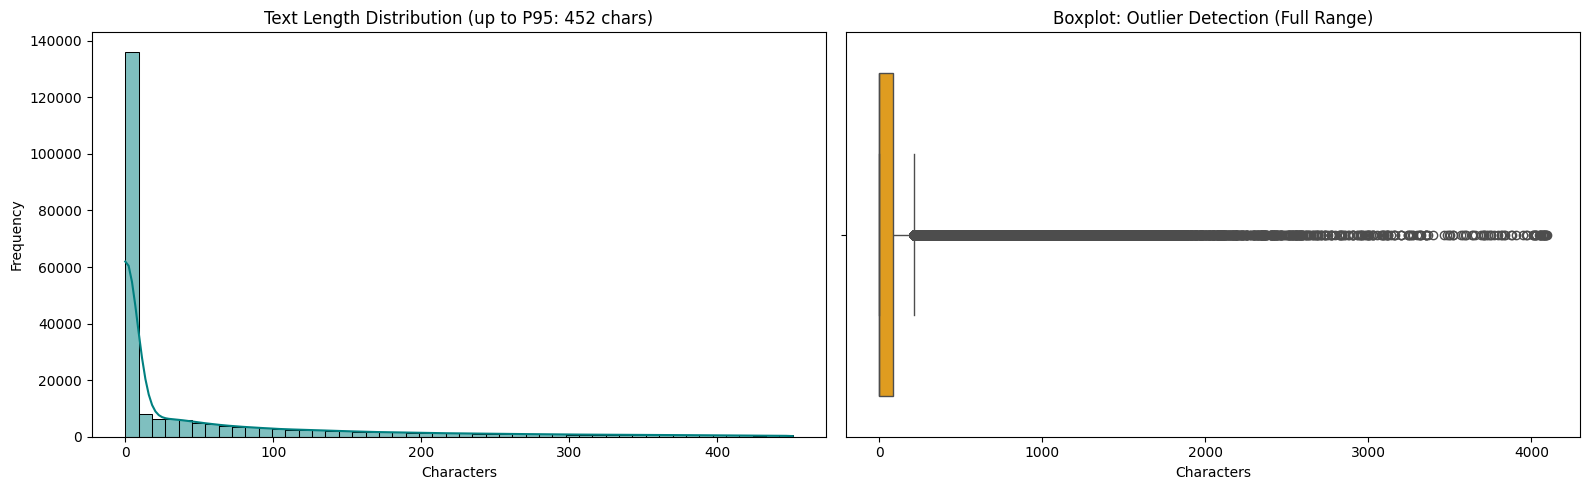

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================================================================
# STRUCTURAL CLEANING
# ==============================================================================

print("Applying structural cleaning (ftfy + whitespace normalization)...")
df_master["review_text_clean"] = df_master["review_text"].apply(clean_text_structure)

# ==============================================================================
# LENGTH STATISTICS
# ==============================================================================

df_master["text_length"] = df_master["review_text_clean"].str.len()

print("\n--- Text Length Statistics (characters) ---")
print(df_master["text_length"].describe().round(2))

quantiles = df_master["text_length"].quantile(
    [0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99, 0.995]
)
print("\nPercentiles:")
print(quantiles)

# ==============================================================================
# VISUALIZATION
# ==============================================================================

fig, ax = plt.subplots(1, 2, figsize=(16, 5))

# Histogram (limit to 95th percentile for readability)
p95 = df_master["text_length"].quantile(0.95)
sns.histplot(
    df_master[df_master["text_length"] < p95]["text_length"],
    bins=50,
    kde=True,
    ax=ax[0],
    color="teal",
)
ax[0].set_title(f"Text Length Distribution (up to P95: {int(p95)} chars)")
ax[0].set_xlabel("Characters")
ax[0].set_ylabel("Frequency")

# Boxplot (full range to inspect outliers)
sns.boxplot(x=df_master["text_length"], ax=ax[1], color="orange")
ax[1].set_title("Boxplot: Outlier Detection (Full Range)")
ax[1].set_xlabel("Characters")

plt.tight_layout()
plt.show()


In [ ]:
import os

# ==============================================================================
# OUTLIER FILTERING (Based on text length)
# ==============================================================================

MIN_LEN = 40
MAX_LEN = 1350

print("Applying quality filters...")
print(f"Length thresholds: min={MIN_LEN}, max={MAX_LEN}")
print(f"Initial total: {len(df_master)}")

# Filter based on length
before_len = len(df_master)
mask_valid = (df_master["text_length"] >= MIN_LEN) & (df_master["text_length"] <= MAX_LEN)
df_master = df_master[mask_valid].copy()

# Replace main text column with the cleaned version
df_master["review_text"] = df_master["review_text_clean"]
df_master = df_master.drop(columns=["review_text_clean"])

# Final deduplication
before_dedupe = len(df_master)
df_master = df_master.drop_duplicates(subset=["user_id", "review_text"])

# Compute reductions
removed_length = before_len - len(df_master)
removed_dupes = before_dedupe - len(df_master)
removed_total = removed_length + removed_dupes

print(f"\nRemoved by length filter: {removed_length}")
print(f"Removed by deduplication: {removed_dupes}")
print(f"Total removed: {removed_total}")
print(f"Cleaning percentage: {removed_total / before_len:.2%}")
print(f"Final dataset size: {len(df_master)} valid reviews")

Applying quality filters...
Length thresholds: min=40, max=1350
Initial total: 241037

Removed by length filter: 159805
Removed by deduplication: 31
Total removed: 159836
Cleaning percentage: 66.31%
Final dataset size: 81232 valid reviews


In [ ]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
Index: 81232 entries, 0 to 241035
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   review_text         81232 non-null  object
 1   review_en           76370 non-null  object
 2   rating              81232 non-null  int64 
 3   date                81232 non-null  object
 4   user_name           81232 non-null  object
 5   user_total_reviews  81232 non-null  int64 
 6   user_id             81232 non-null  object
 7   is_local_guide      81232 non-null  bool  
 8   lang                81232 non-null  object
 9   park_name           81232 non-null  object
 10  text_length         81232 non-null  int64 
dtypes: bool(1), int64(3), object(7)
memory usage: 6.9+ MB


In [ ]:
import unicodedata

def audit_and_clean_noise(df):
    """Detect and clean noisy patterns in review text."""

    initial_count = len(df)

    # ------------------------------------------------------------------
    # 1. DETECTION
    # ------------------------------------------------------------------

    # A. Fancy Unicode text (Mathematical Alphanumeric Symbols)
    fancy_pattern = r'[\U0001D400-\U0001D7FF]'
    fancy_mask = df["review_text"].str.contains(fancy_pattern, regex=True, na=False)
    n_fancy = fancy_mask.sum()

    print(f"1. Fancy Unicode symbols detected: {n_fancy}")
    if n_fancy > 0:
        print(f"   Example: {df[fancy_mask]['review_text'].iloc[0][:60]}...")

    # B. Scraping interface artifacts (Google UI text)
    scraping_keywords = [
        "Resumen de reseñas de Google",
        "Las reseñas no se verifican",
        "Información general",
        "Foto 1 en revisión",
        "Del propietario",
    ]
    scraping_pattern = "|".join(scraping_keywords)
    scraping_mask = df["review_text"].str.contains(scraping_pattern, case=False, regex=True, na=False)
    n_scraping = scraping_mask.sum()

    print(f"2. Scraping/metadata text detected: {n_scraping}")
    if n_scraping > 0:
        print(f"   Example: {df[scraping_mask]['review_text'].iloc[0][:60]}...")

    # ------------------------------------------------------------------
    # 2. CLEANING
    # ------------------------------------------------------------------

    # A. Normalize fancy Unicode text to NFKC form
    if n_fancy > 0:
        print("   -> Normalizing Unicode characters (NFKC)...")
        df["review_text"] = df["review_text"].apply(
            lambda x: unicodedata.normalize("NFKC", str(x))
        )
    else:
        print("   -> No Unicode normalization required.")

    # B. Drop rows containing scraping artifacts
    if n_scraping > 0:
        print(f"   -> Dropping {n_scraping} scraping-related rows...")
        df = df[~scraping_mask].copy()
    else:
        print("   -> No scraping artifacts found.")

    print(f"--- Completed. Final count: {len(df)} (Removed: {initial_count - len(df)}) ---")

    return df


# Execution
df_master = audit_and_clean_noise(df_master)

1. Fancy Unicode symbols detected: 1
   Example: 𝔹𝕦𝕖𝕟 𝕡𝕒𝕣𝕢𝕦𝕖 𝕡𝕒𝕣𝕒 𝕚𝕣 𝕖𝕟 𝕗𝕒𝕞𝕚𝕝𝕚𝕒. 𝔼𝕟 𝕔𝕦𝕖𝕤𝕥𝕚ó𝕟 𝕒 𝕣𝕖𝕤𝕥𝕒𝕦𝕣𝕒𝕔𝕚ó𝕟 ,...
2. Scraping/metadata text detected: 1
   Example: Fuimos a pasar un domingo de diversión que se convirtió en e...
   -> Normalizing Unicode characters (NFKC)...
   -> Dropping 1 scraping-related rows...
--- Completed. Final count: 81231 (Removed: 1) ---


In [ ]:
# Count before filtering
print(f"Total reviews before filtering: {len(df_master)}")

# Drop rows where the English translation is missing
df_master = df_master.dropna(subset=["review_en"])

# Ensure text type is string
df_master["review_en"] = df_master["review_en"].astype(str)

print(f"Total reviews after removing null English translations: {len(df_master)}")

Total reviews before filtering: 81231
Total reviews after removing null English translations: 76369


In [ ]:
# ==============================================================================
# Temporal feature engineering
# ==============================================================================

def add_temporal_features(df):
    """Create year, month, quarter, month name, and season fields."""

    # Ensure datetime format
    df["date"] = pd.to_datetime(df["date"], errors="coerce")

    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    df["quarter"] = df["date"].dt.quarter
    df["month_name"] = df["date"].dt.month_name()

    # Season classifier (Northern Hemisphere)
    def get_season(month):
        if pd.isna(month):
            return None
        if month in [12, 1, 2]:
            return "Winter"
        elif month in [3, 4, 5]:
            return "Spring"
        elif month in [6, 7, 8]:
            return "Summer"
        else:
            return "Autumn"

    df["season"] = df["month"].apply(get_season)
    return df


# Execution
print("Generating temporal features...")
df_master = add_temporal_features(df_master)
df_master.info()

Generating temporal features...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76369 entries, 0 to 76368
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   review_text         76369 non-null  object             
 1   review_en           76369 non-null  object             
 2   rating              76369 non-null  int64              
 3   date                76369 non-null  datetime64[ns, UTC]
 4   user_name           76369 non-null  object             
 5   user_total_reviews  76369 non-null  int64              
 6   user_id             76369 non-null  object             
 7   is_local_guide      76369 non-null  bool               
 8   lang                76369 non-null  object             
 9   park_name           76369 non-null  object             
 10  text_length         76369 non-null  int64              
 11  year                76369 non-null  int32              
 12  

In [ ]:
!pip install nameparser gender-guesser

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.3/379.3 kB 7.3 MB/s eta 0:00:00


In [ ]:
from nameparser import HumanName
import gender_guesser.detector as gender
import re

# ==============================================================================
# Gender inference based on user names
# ==============================================================================

# Manual priority dictionary (common Spanish names)
hispanic_names = {
    # Male
    "juan": "male", "jose": "male", "carlos": "male", "luis": "male",
    "manuel": "male", "antonio": "male", "francisco": "male", "david": "male",
    "javier": "male", "javi": "male", "daniel": "male", "alejandro": "male",
    "alex": "male", "sergio": "male", "diego": "male", "pablo": "male",
    "miguel": "male", "jorge": "male", "andres": "male", "adrian": "male",
    "mario": "male", "aitor": "male", "iker": "male", "ruben": "male",
    "mikel": "male", "ivan": "male", "alberto": "male", "jaime": "male",
    "enrique": "male", "pedro": "male", "vicente": "male", "hugo": "male",
    "gael": "male", "lucas": "male", "marcos": "male", "alvaro": "male",
    "gonzalo": "male", "roberto": "male", "felipe": "male", "cesar": "male",
    "oscar": "male", "ramon": "male", "eduardo": "male", "angel": "male",
    "nicolas": "male", "santiago": "male", "bruno": "male", "kiko": "male",
    # Female
    "maria": "female", "carmen": "female", "ana": "female", "laura": "female",
    "marta": "female", "raquel": "female", "pilar": "female", "cristina": "female",
    "sara": "female", "alba": "female", "elena": "female", "nuria": "female",
    "paula": "female", "patricia": "female", "beatriz": "female", "bea": "female",
    "eva": "female", "julia": "female", "noelia": "female", "rosa": "female",
    "irene": "female", "lucia": "female", "sofia": "female", "helena": "female",
    "leticia": "female", "ruth": "female", "andrea": "female", "marina": "female",
    "susana": "female", "silvia": "female", "ines": "female", "esther": "female",
    "isabel": "female", "monica": "female", "teresa": "female", "veronica": "female",
    "sonia": "female", "natalia": "female", "diana": "female", "elisa": "female",
    "miriam": "female", "carla": "female", "ariana": "female"
}

# Initialize gender detector
gender_detector = gender.Detector(case_sensitive=False)

def predict_gender(full_name):
    """Infer gender from user name."""
    if not isinstance(full_name, str) or pd.isna(full_name):
        return "unknown"

    # Basic name cleaning
    clean_name = re.sub(r"[^a-zA-ZáéíóúüñÑ ]", " ", str(full_name)).strip().lower()

    # Extract first name
    try:
        first_name = HumanName(clean_name).first
    except:
        return "unknown"

    if not first_name or len(first_name) < 2:
        return "unknown"

    # 1. Manual dictionary priority
    if first_name in hispanic_names:
        return hispanic_names[first_name]

    # 2. Fallback: gender-guesser
    guess = gender_detector.get_gender(first_name)

    if guess in ["male", "mostly_male"]:
        return "male"
    elif guess in ["female", "mostly_female"]:
        return "female"
    else:
        return "unknown"


print("Inferring user gender...")
df_master["gender"] = df_master["user_name"].apply(predict_gender)
df_master.info()

Inferring user gender...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76369 entries, 0 to 76368
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   review_text         76369 non-null  object             
 1   review_en           76369 non-null  object             
 2   rating              76369 non-null  int64              
 3   date                76369 non-null  datetime64[ns, UTC]
 4   user_name           76369 non-null  object             
 5   user_total_reviews  76369 non-null  int64              
 6   user_id             76369 non-null  object             
 7   is_local_guide      76369 non-null  bool               
 8   lang                76369 non-null  object             
 9   park_name           76369 non-null  object             
 10  text_length         76369 non-null  int64              
 11  year                76369 non-null  int32              
 12  month  

In [ ]:
print("\n--- Gender Distribution ---")
print(df_master["gender"].value_counts(normalize=True))

print("\n--- Sample of Enriched Dataset ---")
display(df_master[["date", "season", "gender"]].head(10))



--- Gender Distribution ---
gender
male       0.462648
female     0.320981
unknown    0.216371
Name: proportion, dtype: float64

--- Sample of Enriched Dataset ---


,date,season,gender
0,2025-11-02 21:32:23.184000+00:00,Autumn,male
1,2025-10-28 10:10:44.819000+00:00,Autumn,unknown
2,2025-10-28 08:25:07.303000+00:00,Autumn,female
3,2025-10-27 21:57:54.689000+00:00,Autumn,unknown
4,2025-10-27 20:03:59.497000+00:00,Autumn,female
5,2025-10-27 16:31:16.353000+00:00,Autumn,male
6,2025-10-27 16:10:57.425000+00:00,Autumn,male
7,2025-10-27 14:34:07.346000+00:00,Autumn,male
8,2025-10-27 11:20:05.260000+00:00,Autumn,unknown
9,2025-10-27 10:23:14.681000+00:00,Autumn,male


In [ ]:
# Remove user name column (PII)
if "user_name" in df_master.columns:
    df_master = df_master.drop(columns=["user_name"])
    print("Column 'user_name' removed for privacy.")

Column 'user_name' removed for privacy.
